In [530]:
import pandas as pd
import pvlib
from pvlib.location import Location
import matplotlib.pyplot as plt
import numpy as np
from sympy import*
from scipy.optimize import curve_fit
from scipy import integrate # indlæses også senere i selve opgaven

In [531]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "Min"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Højde er ca 50 m MOH

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:59", inclusive="left", freq=delta_tid, tz=tidszone
)

# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)


### Ny kode

In [620]:
theta_sol = np.deg2rad(solpos.loc["2024-04-20"].zenith.values)
phi_sol = np.deg2rad(solpos.loc["2024-04-20"].azimuth.values)

In [619]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    nLB = 0.18*1.63*550 # n er overførelsen, altså hvor meget energi fra solen er arbejdsom, målt fra når den rammer pannelet til den kommer ind i et andet kredsløb
    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])
    dot_products = nLB * np.sum(u_s * u_p, axis=-1)
    return np.maximum(dot_products, 0)

In [621]:
flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

In [622]:
from scipy import integrate

energi = integrate.simpson(flux_array, dx=60)  # i [W·s] eller Joule

In [623]:
energi_Wh = energi / 3600
energi_Wh

797.3063540597645

In [624]:
phi_panel = np.deg2rad(180)
energier = []
wh_energier = []

for vinkel in range(0, 90):  # 0° til 90°
    theta_panel = np.deg2rad(vinkel)
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
    energi = integrate.simpson(flux_array, dx=60)
    energier.append(energi)
    wh_energier.append(energi/3600)


energier # i enheden Joule pr sekunder
wh_energier # i enheden kWh 

[1040.982187726094,
 1052.729971711041,
 1064.2413960710464,
 1075.507419582715,
 1086.521538170495,
 1097.272293790891,
 1107.7524271413386,
 1117.9550491890773,
 1127.8734018340062,
 1137.500863236732,
 1146.8309531039367,
 1155.8606341976238,
 1164.584982679518,
 1172.9949350531638,
 1181.0889905687968,
 1188.8586020808252,
 1196.3081076398119,
 1203.4260668583179,
 1210.2102246984844,
 1216.6594871386683,
 1222.7693200045262,
 1228.5337984114137,
 1233.957336945545,
 1239.0304103482554,
 1243.7513308288371,
 1248.1227613349217,
 1252.1356112270491,
 1255.7949239081179,
 1259.0915991608665,
 1262.0312810292091,
 1264.6057371114455,
 1266.8199318502527,
 1268.666488137581,
 1270.1502292085368,
 1271.2646339811465,
 1272.0147648771303,
 1272.3939795605452,
 1272.4075154235068,
 1272.0493833284945,
 1271.324714484137,
 1270.2281612607546,
 1268.7647470749491,
 1266.9303551505918,
 1264.7292918250373,
 1262.1599403644018,
 1259.2226942163752,
 1255.9203078695887,
 1252.249648359137,
 12

In [625]:
np.sum(wh_energier)

102723.26616888585

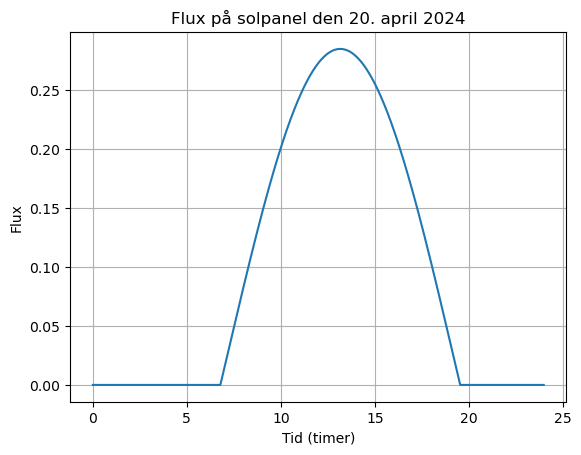

In [595]:
time_index = solpos.loc["2024-04-20"].index
time_array = np.array([t.hour + t.minute/60 for t in time_index])

flux = solar_panel_projection(theta_sol, phi_sol, np.deg2rad(30), np.deg2rad(180))
plt.plot(time_array, flux)
plt.xlabel("Tid (timer)")
plt.ylabel("Flux")
plt.title("Flux på solpanel den 20. april 2024")
plt.grid()
plt.show()

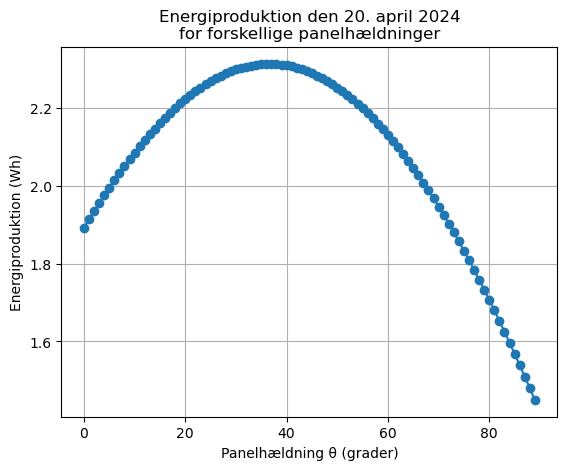

In [596]:
hældninger = np.arange(0, 90)  # 0° til 90°
plt.plot(hældninger, wh_energier, marker='o')
plt.xlabel("Panelhældning θ (grader)")
plt.ylabel("Energiproduktion (Wh)")
plt.title("Energiproduktion den 20. april 2024\nfor forskellige panelhældninger")
plt.grid(True)
plt.show()

In [597]:
np.sum(wh_energier)

186.7695748525197

In [541]:
maks_energi = max(energier)
optimal_vinkel = hældninger[np.argmax(energier)]

maks_energi, optimal_vinkel

(8328.485555499316, 37)

---

In [598]:
theta_sol = np.deg2rad(solpos.loc["2024-01-01":"2024-12-31"].zenith.values)
phi_sol = np.deg2rad(solpos.loc["2024-01-01":"2024-12-31"].azimuth.values)

In [606]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    nLB = 0.18*1.63 *550 # n er overførelsen, altså hvor meget energi fra solen er arbejdsom, målt fra når den rammer pannelet til den kommer ind i et andet kredsløb
    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])
    dot_products = nLB* np.sum(u_s * u_p, axis=-1)
    return np.maximum(dot_products, 0)

In [607]:
flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

In [608]:
from scipy import integrate

energi = integrate.simpson(flux_array, dx=60)  # i [W·s] eller Joule

In [609]:
energi_Wh = energi / 3600
energi_Wh

328479.4633568925

In [616]:
phi_panel = np.deg2rad(180)
energier = []
wh_energier = []

for vinkel in range(0, 90):  # 0° til 90°
    theta_panel = np.deg2rad(vinkel)
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
    energi = integrate.simpson(flux_array, dx=60)
    energier.append(energi)
    wh_energier.append(energi/3600)


energier # i enheden Joule pr sekunder
wh_energier # i enheden kWh 

[272005.1739137616,
 276955.31421445217,
 281856.79789219925,
 286705.1635542354,
 291496.4259698794,
 296226.78735233063,
 300892.828519539,
 305491.3143802308,
 310019.28974042885,
 314473.91935393494,
 318852.56710349943,
 323152.71754737885,
 327372.03035166126,
 331508.2671518513,
 335559.2770891444,
 339523.0350293977,
 343397.6459315208,
 347181.2209834155,
 350872.0052083207,
 354468.32618834,
 357968.5651763208,
 361371.17852449615,
 364674.68832279614,
 367877.6771857883,
 370978.8056455957,
 373976.76895675896,
 376870.32025509153,
 379658.28719029983,
 382339.5565226724,
 384913.0308824555,
 387377.69372035423,
 389732.5248843034,
 391976.6912923582,
 394109.22584324935,
 396129.35717049835,
 398036.2714762814,
 399829.24079533346,
 401507.56785569055,
 403070.61455473513,
 404517.7603665279,
 405848.4796593806,
 407062.25906890625,
 408158.60944132594,
 409137.1339607917,
 409997.43427612545,
 410739.16696826444,
 411362.0604396568,
 411865.8238028052,
 412250.3389827584,


In [617]:
max(wh_energier)

412686.4468801147

In [618]:
np.sum(wh_energier)

33465886.62051306

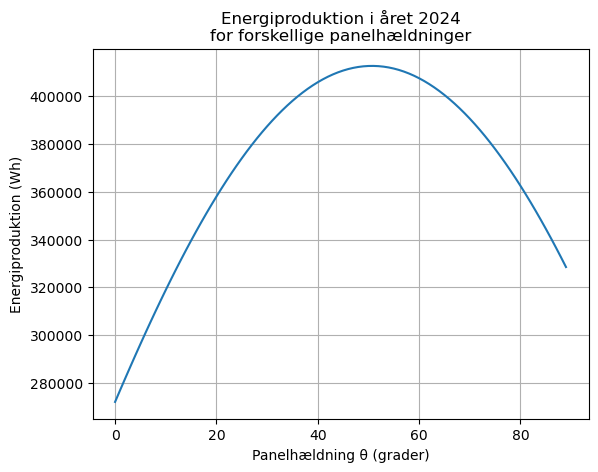

In [612]:
hældninger = np.arange(0, 90)  # 0° til 90°
plt.plot(hældninger, wh_energier)
plt.xlabel("Panelhældning θ (grader)")
plt.ylabel("Energiproduktion (Wh)")
plt.title("Energiproduktion i året 2024\nfor forskellige panelhældninger")
plt.grid(True)
plt.show()

maks_energi = max(energier)
optimal_vinkel = hældninger[np.argmax(energier)]


In [614]:
maks_energi = max(wh_energier)
optimal_vinkel = hældninger[np.argmax(wh_energier)]

maks_energi , optimal_vinkel

(412686.4468801147, 51)

---

In [628]:
theta_sol = np.deg2rad(solpos.loc["2024-01-01":"2024-12-31"].zenith.values)
phi_sol = np.deg2rad(solpos.loc["2024-01-01":"2024-12-31"].azimuth.values)

In [629]:
flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

In [630]:
from scipy import integrate

energi = integrate.simpson(flux_array, dx=60)  # i [W·s] eller Joule

In [631]:
energi_Wh = energi / 3600
energi_Wh

597.2353879216226

In [632]:
# def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
#     theta_sol = np.asarray(theta_sol)
#     phi_sol = np.asarray(phi_sol)
#     nLB = 0.18*1.63 # n er overførelsen, altså hvor meget energi fra solen er arbejdsom, målt fra når den rammer pannelet til den kommer ind i et andet kredsløb
#     u_s = np.array([
#         np.sin(theta_sol) * np.cos(phi_sol),
#         np.sin(theta_sol) * np.sin(phi_sol),
#         np.cos(theta_sol)
#     ])

#     u_p = np.array([
#         np.sin(theta_panel) * np.cos(phi_panel),
#         np.sin(theta_panel) * np.sin(phi_panel),
#         np.cos(theta_panel)
#     ])
#     dot_products = nLB* u_s.dot(u_p)
#     return np.maximum(dot_products, 0)

phi_panel = np.deg2rad(20)
energier = []
wh_energier = []

for vinkel in range(0, 9):  # 0° til 90°
    theta_panel = np.deg2rad(vinkel)
    #print(theta_sol.shape, phi_sol.shape, theta_panel, phi_panel)
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
    # print(flux_array)
    energi = integrate.simpson(flux_array, dx=60)
    energier.append(energi)
    wh_energier.append(energi / 3600)


energier # i enheden Joule pr sekunder
wh_energier # i enheden kWh 


[494.5548616613849,
 486.02599074755824,
 477.4374267871278,
 468.7992535567365,
 460.1226480601367,
 451.42000609075393,
 442.70523115316036,
 433.9942856065971,
 425.305533141218]

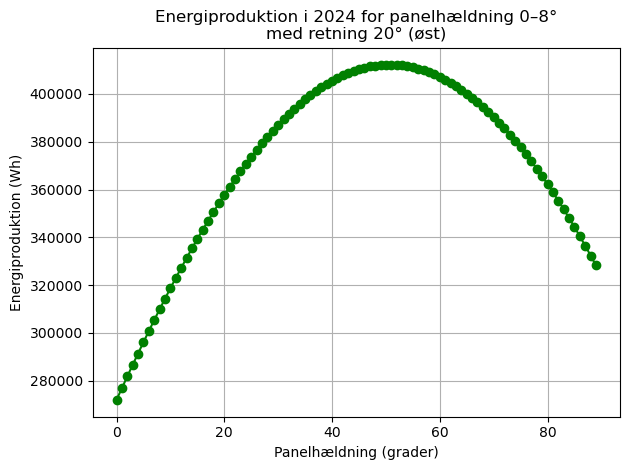

In [637]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

# Solar angles (assumed already defined):
# theta_sol, phi_sol

def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)

    nLB = 0.18 * 1.63*550  # Efficiency * cell area [assumed effective factor]

    u_s = np.array([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ])

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])

    dot_products = nLB * np.einsum('ij,i->j', u_s, u_p)  # Efficient dot product
    return np.maximum(dot_products, 0)

# Settings
phi_panel = np.deg2rad(175)
energier = []
wh_energier = []
hældninger = np.arange(0, 90)

for vinkel in hældninger:
    theta_panel = np.deg2rad(vinkel)

    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0
    )

    energi = integrate.simpson(flux_array, dx=60)  # Joule
    energier.append(energi)
    wh_energier.append(energi / 3600)  # Wh

# Plot
plt.plot(hældninger, wh_energier, marker='o', color='green')
plt.xlabel("Panelhældning (grader)")
plt.ylabel("Energiproduktion (Wh)")
plt.title("Energiproduktion i 2024 for panelhældning 0–8°\nmed retning 20° (øst)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [638]:
np.sum(wh_energier)

33436439.692986783

In [639]:
33465886.6-33436439.692986783

29446.90701321885

In [556]:
max(energier) , np.argmax(wh_energier)


(2701220.379578934, 51)

In [557]:
2701220.379578934 - 2698361.0198466405

2859.359732293524

In [558]:
1194137.99/3600000

0.33170499722222224

In [559]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    nLB = 0.18*1.63 # n er overførelsen, altså hvor meget energi fra solen er arbejdsom, målt fra når den rammer pannelet til den kommer ind i et andet kredsløb
    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])
    dot_products = nLB* np.sum(u_s * u_p, axis=-1)
    return np.maximum(dot_products, 0)

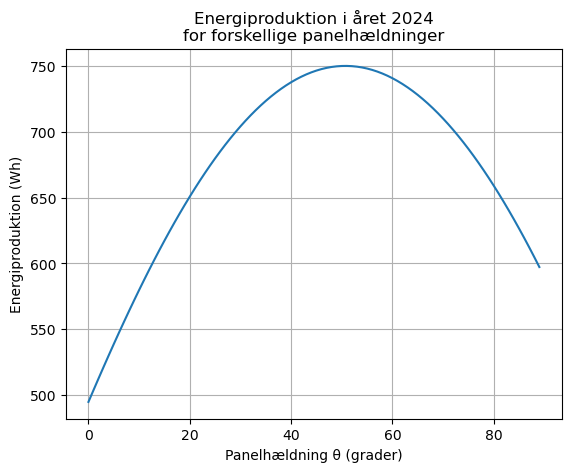

In [560]:
hældninger = np.arange(0, 90)  # 0° til 90°
plt.plot(hældninger, wh_energier)
plt.xlabel("Panelhældning θ (grader)")
plt.ylabel("Energiproduktion (Wh)")
plt.title("Energiproduktion i året 2024\nfor forskellige panelhældninger")
plt.grid(True)
plt.show()

maks_energi = max(energier)
optimal_vinkel = hældninger[np.argmax(energier)]


In [561]:
#maks_energi1 = max(energier)
#optimal_vinkel = hældninger[np.argmax(energier)]

#maks_energi1 , optimal_vinkel

np.sum(energier)

219049439.69790366

In [562]:
maks_energi1 - maks_energi

0.0

---

In [563]:
theta_sol = np.deg2rad(solpos.loc["2024-01-01":"2024-12-31"].zenith.values)
phi_sol = np.deg2rad(solpos.loc["2024-01-01":"2024-12-31"].azimuth.values)

In [564]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    nLB = 0.18*1.63 # n er overførelsen, altså hvor meget energi fra solen er arbejdsom, målt fra når den rammer pannelet til den kommer ind i et andet kredsløb
    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])
    dot_products = nLB* np.sum(u_s * u_p, axis=-1)
    return np.maximum(dot_products, 0)

In [565]:
flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

In [566]:
from scipy import integrate

energi = integrate.simpson(flux_array, dx=60)  # i [W·s] eller Joule

In [567]:
energi

2150047.3965178416

In [568]:
energi_Wh = energi / 3600
energi_Wh

597.2353879216226

In [569]:
phi_panel = np.deg2rad(180)
energier = []
wh_energier = []

for vinkel in range(0, 90):  # 0° til 90°
    theta_panel = np.deg2rad(vinkel)
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
    energi = integrate.simpson(flux_array, dx=60)
    energier.append(energi)
    wh_energier.append(energi/3600)


energier # i enheden Joule pr sekunder
wh_energier # i enheden kWh 

[494.5548616613849,
 503.5551167535495,
 512.466905258544,
 521.2821155531553,
 529.993501763417,
 538.5941588224191,
 547.0778700355254,
 555.4387534186012,
 563.6714358916887,
 571.7707624616999,
 579.7319401881809,
 587.5503955406888,
 595.2218733666567,
 602.7423039124569,
 610.1077765257173,
 617.3146091443593,
 624.3593562391288,
 631.23858360621,
 637.9491003787648,
 644.487865796982,
 650.8519366842198,
 657.0385064081748,
 663.0448878596296,
 668.8685039741603,
 674.5069193556285,
 679.9577617395616,
 685.2187641001665,
 690.287794891454,
 695.1628300412226,
 699.8418743317372,
 704.3230794915534,
 708.6045906987333,
 712.6848932588333,
 716.5622288059078,
 720.2351948554514,
 723.7023117750574,
 726.9622559915152,
 730.0137597376194,
 732.8556628267913,
 735.4868370300507,
 737.9063266534192,
 740.1131983071023,
 742.1065626205927,
 743.8856981105306,
 745.4498805020462,
 746.7984853968445,
 747.9310189811941,
 748.8469523687369,
 749.5460708777427,
 750.0277927221704,
 750.2

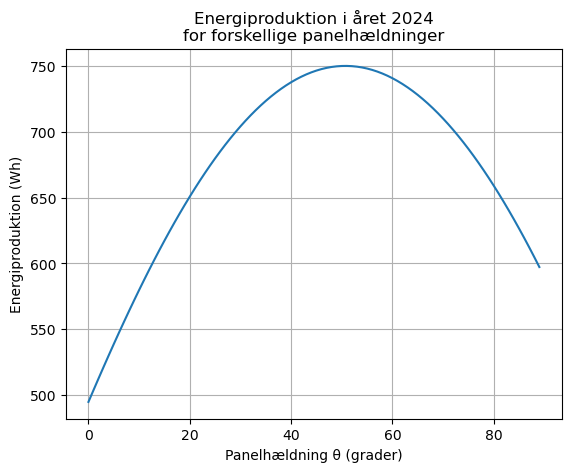

In [570]:
hældninger = np.arange(0, 90)  # 0° til 90°
plt.plot(hældninger, wh_energier)
plt.xlabel("Panelhældning θ (grader)")
plt.ylabel("Energiproduktion (Wh)")
plt.title("Energiproduktion i året 2024\nfor forskellige panelhældninger")
plt.grid(True)
plt.show()

maks_energi = max(energier)
optimal_vinkel = hældninger[np.argmax(energier)]


In [571]:
# EXAMPLE 

delta_time = "h"
year_2024 = get_solar_position("2024-01-01", "2024-12-31",delta_time=delta_time)

result = []
phi_p = 180
for theta_p in range(91):
    p = solar_panel_power(year_2024, theta_p, phi_p)
    result.append(p)
sns.lineplot(result)
np.argmax(result), J_to_kWh(max(result))

NameError: name 'sns' is not defined

In [ ]:
def get_solar_position(start_dato, slut_dato, lat=55.47092, lon=12.31168, altitude=10, time_zone="Europe/Copenhagen", delta_time="h"):
    start_dato = "2024-01-01"
    slut_dato = "2024-12-31"
    delta_tid = "H"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
    site = Location(
        55.47092, 12.31168, tidszone, 10,"Danmarks Tekniske Universitet (DK)"
    )  # latitude, longitude, time_zone, altitude, name

# Definition of a time range of simulation
    time = pd.date_range(
        start_dato + " 00:00:00", slut_dato + " 23:59:59", inclusive="left", freq=delta_tid, tz=tidszone
    )
    return site.get_solarposition(time)

In [ ]:
solpos = site.get_solarposition(times)

In [ ]:
def get_solar_position(start_date, end_date, lat=55.785009, lon=12.520051, altitude=10, time_zone="Europe/Copenhagen", delta_time="h"):
    site = Location(lat, lon, time_zone, 10, "DTU")

    time = pd.date_range(start_date + " 00:00:00", end_date + " 23:59:00", inclusive="left", freq=delta_time, tz=time_zone)

    return site.get_solarposition(time)

In [ ]:
solpos

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2024-01-01 00:00:00+01:00,147.491022,147.491022,-57.491022,-57.491022,354.081669,-3.055576
2024-01-01 01:00:00+01:00,146.478485,146.478485,-56.478485,-56.478485,19.472389,-3.075359
2024-01-01 02:00:00+01:00,142.115511,142.115511,-52.115511,-52.115511,42.023025,-3.095135
2024-01-01 03:00:00+01:00,135.483097,135.483097,-45.483097,-45.483097,60.475679,-3.114902
2024-01-01 04:00:00+01:00,127.607106,127.607106,-37.607106,-37.607106,75.662194,-3.134661
...,...,...,...,...,...,...
2024-12-31 19:00:00+01:00,115.215154,115.215154,-25.215154,-25.215154,265.516458,-3.320293
2024-12-31 20:00:00+01:00,123.691308,123.691308,-33.691308,-33.691308,278.044069,-3.340071
2024-12-31 21:00:00+01:00,131.880808,131.880808,-41.880808,-41.880808,292.138153,-3.359839
2024-12-31 22:00:00+01:00,139.193733,139.193733,-49.193733,-49.193733,308.916260,-3.379598


In [ ]:
import numpy as np
from scipy import integrate

def solar_panel_power(day, theta_panel_deg, phi_panel_deg, area=1.63, efficiency=0.18):
    """
    Calculates a relative daily energy output based on sun position and panel orientation.

    Parameters:
    - day: DataFrame with 'zenith' and 'azimuth' columns
    - theta_panel_deg: panel tilt angle in degrees
    - phi_panel_deg: panel azimuth angle in degrees
    - area: panel area (m²)
    - efficiency: panel efficiency (0–1)

    Returns:
    - Daily energy in kWh (scaled with area and efficiency)
    """
    theta_sol = np.deg2rad(day["zenith"].values)
    phi_sol = np.deg2rad(day["azimuth"].values)
    theta_panel = np.deg2rad(theta_panel_deg)
    phi_panel = np.deg2rad(phi_panel_deg)

    # Unit vectors
    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])

    # Cosine projection
    flux = np.maximum(np.sum(u_s * u_p, axis=-1), 0)

    # Power in W, assuming 1000 W/m² peak irradiance
    power = flux * area * efficiency * 1000

    # Integrate over day (e.g. 1-hour steps = 3600s)
    energy = integrate.simpson(power, dx=3600)  # Joules
    return energy / 3.6e6  # Convert to kWh


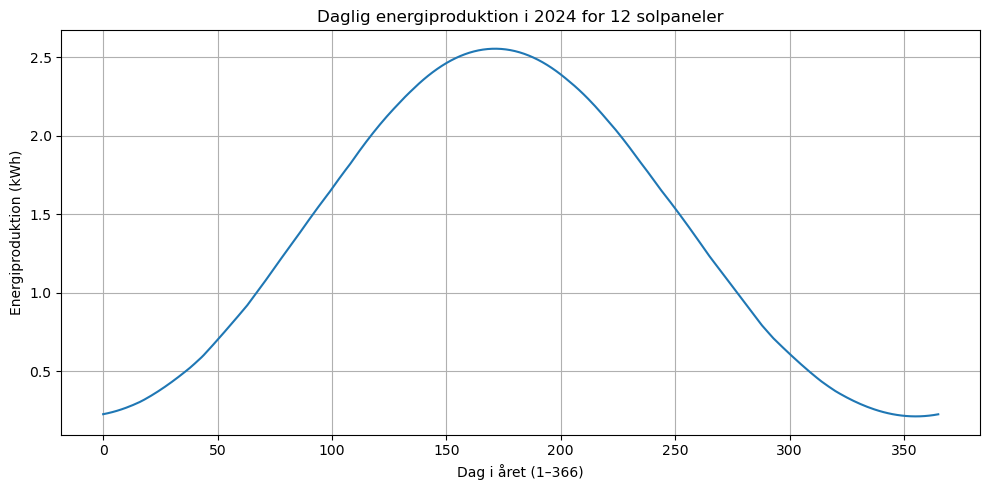

In [ ]:
import matplotlib.pyplot as plt

# Panel setup
n_panels = 12
phi_p = np.deg2rad(180)     # south-facing
theta_p = np.deg2rad(51)   # optimal tilt in Denmark

# Get solar position data for 2024
year_2024 = get_solar_position("2024-01-01", "2024-12-31", delta_time="1h")

# Compute daily energy production
daily_energy = []

for day_num in range(366):  # Leap year
    day = year_2024[day_num*24 : day_num*24 + 24]

    p = solar_panel_power(day, theta_p, phi_p)
    daily_energy.append(p)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(daily_energy)
plt.xlabel("Dag i året (1–366)")
plt.ylabel("Energiproduktion (kWh)")
plt.title("Daglig energiproduktion i 2024 for 12 solpaneler")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def solar_power(daily_data , theta_panel , phi_panel , delta_tid = 'D'):
    flux = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
    energy = integrate.simpson(power, dx=3600)
    return energy

In [ ]:
x =12 
theta_panel = np.deg2rad(50.9)
phi_panel = np.deg2rad(180)
theta_sol = np.deg2rad(solpos.loc["2024-01-01":"2024-12-31"].zenith.values)
phi_sol = np.deg2rad(solpos.loc["2024-01-01":"2024-12-31"].azimuth.values)

result = []
for day_num in range(366):  # Leap year
    day = year_2024[day_num*24 : day_num*24 + 24]
    p = solar_power(day, theta_panel, phi_panel)
    result.append(p)


NameError: name 'power' is not defined

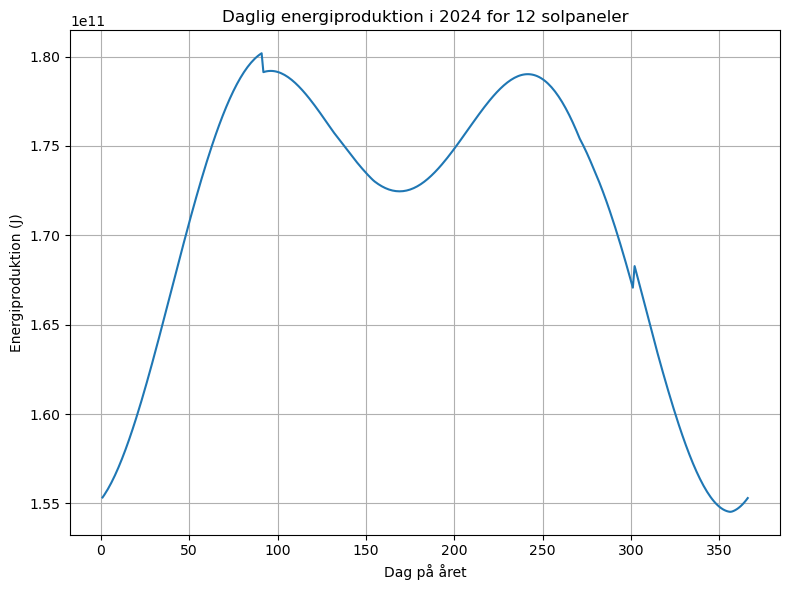

In [640]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from pvlib.solarposition import get_solarposition

# Panel setup
panel_effekt = 280 *nLB *550  # W
antal_paneler = 12
theta_panel = np.deg2rad(50.9)
phi_panel = np.deg2rad(180)

# Time range
delta_time = '1h'
times = pd.date_range('2024-01-01', '2024-12-31 23:59', freq=delta_time, tz='Europe/Copenhagen')
solpos = get_solarposition(times, latitude=55.785009, longitude=12.520051)  # Example: Copenhagen

# Convert angles
theta_sol = np.deg2rad(solpos['zenith'].values)
phi_sol = np.deg2rad(solpos['azimuth'].values)

# Function for projected power
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)
    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])
    dot = np.dot(u_s, u_p)
    return np.maximum(dot, 0)

# Compute daily energy
daily_energy = []
for day in pd.date_range('2024-01-01', '2024-12-31'):
    day_mask = times.date == day.date()
    proj = solar_panel_projection(theta_sol[day_mask], phi_sol[day_mask], theta_panel, phi_panel)
    flux = proj * panel_effekt * antal_paneler  # W
    samlet_flux = antal_paneler * flux
    energy = integrate.simpson(samlet_flux, dx=3600)  # J
    daily_energy.append(energy)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 367), daily_energy)
plt.xlabel("Dag på året")
plt.ylabel("Energiproduktion (J)")
plt.title("Daglig energiproduktion i 2024 for 12 solpaneler")
plt.grid(True)
plt.tight_layout()
plt.show()


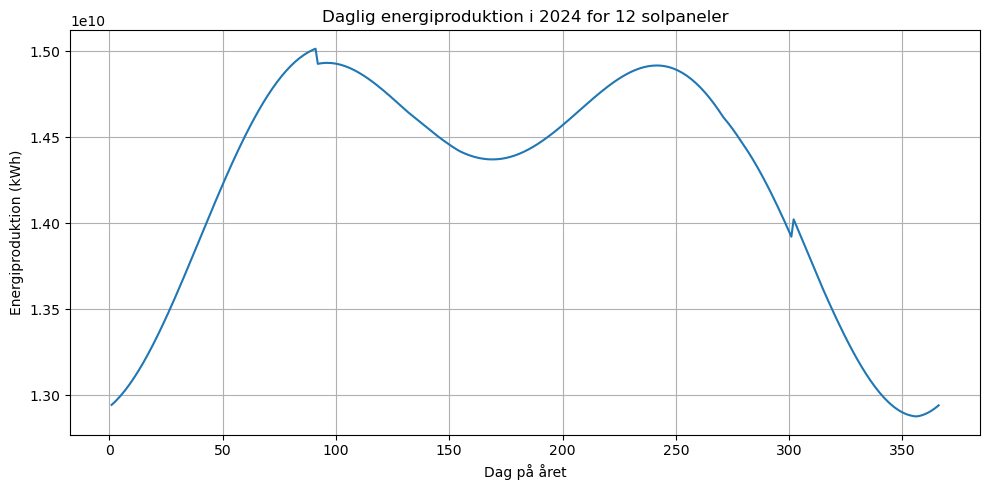

In [641]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate

# Parameters
panel_effekt = 280*nLB*550  # W per panel (example)
antal_paneler = 12
theta_panel = np.deg2rad(50.9)   # optimal tilt for DK
phi_panel = np.deg2rad(180)    # south-facing

# Assuming 'solpos' is a DataFrame with datetime index and 'zenith'/'azimuth' columns
times = solpos.index
dates = pd.date_range('2024-01-01', '2024-12-31')

daily_energy = []

for date in dates:
    # Get data for one day
    day_data = solpos.loc[date.strftime('%Y-%m-%d')]
    theta_day = np.deg2rad(day_data['zenith'].values)
    phi_day = np.deg2rad(day_data['azimuth'].values)

    # Projection and flux
    proj = solar_panel_projection(theta_day, phi_day, theta_panel, phi_panel)
    flux = proj * panel_effekt * antal_paneler  # W

    # Integrate to get energy in joules
    energy = integrate.simpson(flux, dx=3600)
    daily_energy.append(energy)

# Convert to kWh
daily_energy_kWh = np.array(daily_energy) / 3.6e6

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, 367), daily_energy)
plt.xlabel("Dag på året")
plt.ylabel("Energiproduktion (kWh)")
plt.title("Daglig energiproduktion i 2024 for 12 solpaneler")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
np.sum(daily_energy)

32291397930.06344